In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.8.0
GPU is available


In [2]:
!nvidia-smi

Thu Nov 26 13:35:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
image_size = 224

## Creating DataGenerator

In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")
batch_size = 32
train_data = train_datagen.flow_from_directory(os.path.join(base_dir,"train"),
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical"                                               
                                              )

Found 70295 images belonging to 38 classes.


In [5]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
test_data = test_datagen.flow_from_directory(os.path.join(base_dir,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical"                                               
                                              )

Found 17572 images belonging to 38 classes.


In [6]:
categories = list(train_data.class_indices.keys())
print(categories)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [7]:
train_data.image_shape

(224, 224, 3)

## Using MobileNet

In [8]:
base_model = keras.applications.MobileNet(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

17227776/17225924 [==============================] - 0s 0us/step


In [9]:

base_model.trainable = False
inputs = keras.Input(shape=(image_size,image_size,3))
x = base_model(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(categories),activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=x, name="LeafDisease_MobileNet")

In [10]:
model.summary()

Model: "LeafDisease_MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                38950     
Total params: 3,267,814
Trainable params: 38,950
Non-trainable params: 3,228,864
_________________________________________________________________


In [11]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit_generator(train_data,
          validation_data=test_data,
          epochs=40,
          steps_per_epoch=150,
          validation_steps=100,
          callbacks = early_stopping
         )

Epoch 1/40
150/150 [==============================] - 82s 548ms/step - loss: 3.1349 - categorical_accuracy: 0.6342 - val_loss: 2.9911 - val_categorical_accuracy: 0.7503
Epoch 2/40
150/150 [==============================] - 81s 540ms/step - loss: 2.9936 - categorical_accuracy: 0.7492 - val_loss: 2.9347 - val_categorical_accuracy: 0.7900
Epoch 3/40
150/150 [==============================] - 77s 516ms/step - loss: 2.9575 - categorical_accuracy: 0.7715 - val_loss: 2.8927 - val_categorical_accuracy: 0.8288
Epoch 4/40
150/150 [==============================] - 76s 509ms/step - loss: 2.9158 - categorical_accuracy: 0.8092 - val_loss: 2.8788 - val_categorical_accuracy: 0.8347
Epoch 5/40
150/150 [==============================] - 76s 505ms/step - loss: 2.8824 - categorical_accuracy: 0.8356 - val_loss: 2.8671 - val_categorical_accuracy: 0.8416
Epoch 6/40
150/150 [==============================] - 74s 492ms/step - loss: 2.8937 - categorical_accuracy: 0.8188 - val_loss: 2.8700 - val_categorical_acc

In [15]:
model.evaluate(test_data)

550/550 [==============================] - 46s 83ms/step - loss: 2.7593 - categorical_accuracy: 0.9309


[2.7592875957489014, 0.930855929851532]

In [16]:
model.save('mobileNet-cnn.h5')

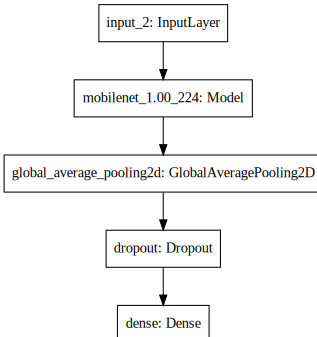

In [17]:
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

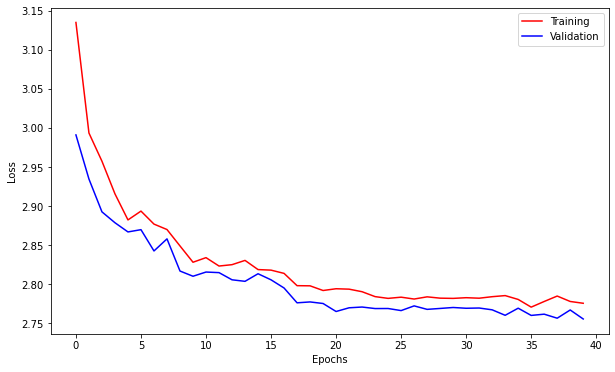

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

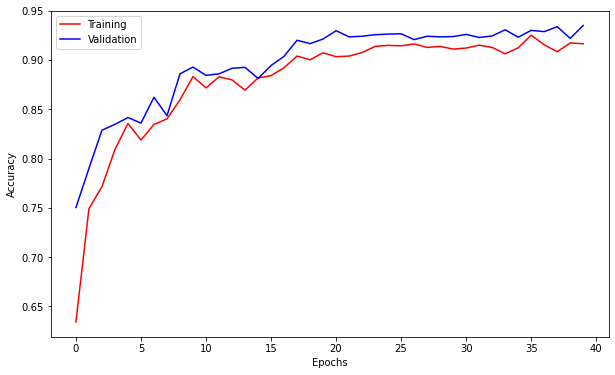

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [39]:
saved_model_path = "..output/tmp/saved_retval_model"
tf.saved_model.save(model, saved_model_path)

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 12664KBs.


In [41]:
 # Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 3228KBs,
which is about 25% of the float model size.


In [42]:
f = open('plant_model.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

## Using mobileNet v2

In [20]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [21]:
do_fine_tuning = False

In [22]:
print("Building model with", MODULE_HANDLE)
model_NetV2 = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_data.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model_NetV2.build((None,)+IMAGE_SIZE+(3,))
model_NetV2.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model_NetV2.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [24]:
## lets train our CNN
model_2 = model_NetV2.fit(train_data,validation_data= test_data,epochs = 40, steps_per_epoch = 150,
            validation_steps = 100, callbacks= early_stopping).history


Epoch 1/40
150/150 [==============================] - 73s 484ms/step - loss: 2.2455 - accuracy: 0.5033 - val_loss: 1.4393 - val_accuracy: 0.7775
Epoch 2/40
150/150 [==============================] - 70s 469ms/step - loss: 1.4690 - accuracy: 0.7540 - val_loss: 1.3228 - val_accuracy: 0.8141
Epoch 3/40
150/150 [==============================] - 69s 461ms/step - loss: 1.3558 - accuracy: 0.7973 - val_loss: 1.2619 - val_accuracy: 0.8322
Epoch 4/40
150/150 [==============================] - 68s 455ms/step - loss: 1.3035 - accuracy: 0.8215 - val_loss: 1.2198 - val_accuracy: 0.8506
Epoch 5/40
150/150 [==============================] - 69s 459ms/step - loss: 1.2664 - accuracy: 0.8366 - val_loss: 1.1528 - val_accuracy: 0.8828
Epoch 6/40
150/150 [==============================] - 72s 483ms/step - loss: 1.2325 - accuracy: 0.8535 - val_loss: 1.1405 - val_accuracy: 0.8869
Epoch 7/40
150/150 [==============================] - 70s 468ms/step - loss: 1.2364 - accuracy: 0.8502 - val_loss: 1.1325 - val_ac

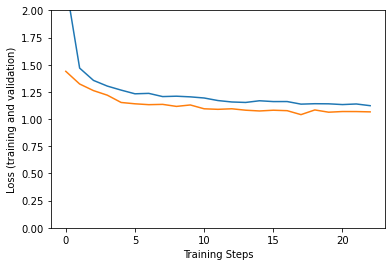

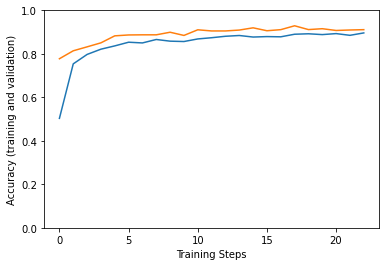

In [25]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(model_2["loss"])
plt.plot(model_2["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(model_2["accuracy"])
plt.plot(model_2["val_accuracy"])

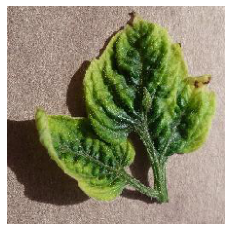

True label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [26]:
def get_class_string_from_index(index):
   for class_string, class_index in test_data.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_data)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [34]:
saved_model_path = "./saved_mobilenetV2_model"
tf.saved_model.save(model, saved_model_path)

In [35]:
# TODO(b/156102192)
optimize_lite_model = False 
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("./lite_mobilenetv2_model.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 12991584 bytes.


In [36]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [37]:
num_eval_examples = 50 
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_data
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 50 of 50 examples (100%).
TF Lite model is accurate on 44 of 50 examples (88%).


## Using alexNet

In [43]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.layers.normalization import BatchNormalization

# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 38, activation = 'softmax'))
classifier.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)        

In [44]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)        

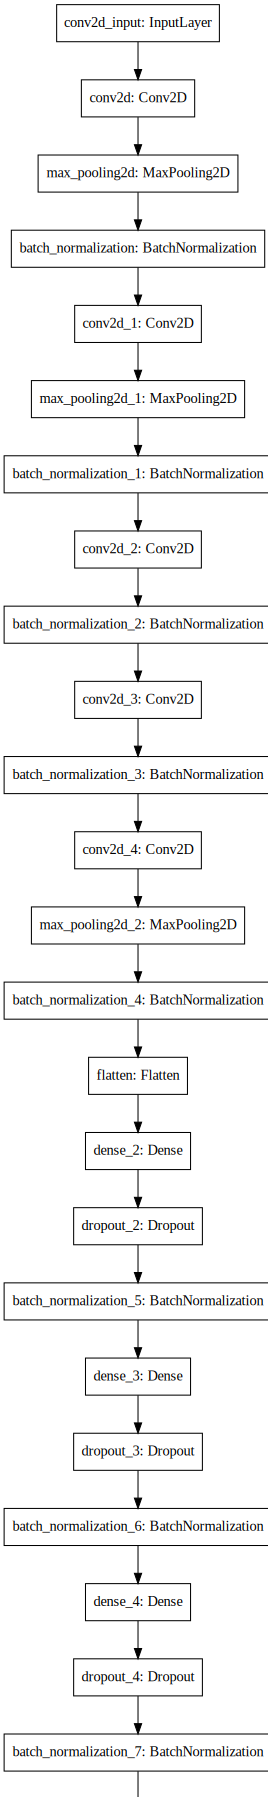

In [45]:
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(classifier, dpi=70).create(prog='dot', format='svg'))

In [46]:
classifier.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9, decay=0.005), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [47]:
## lets train our CNN
alexNet = classifier.fit(train_data,validation_data= test_data,epochs = 40, steps_per_epoch = 1500,
            validation_steps = 1000, callbacks= early_stopping).history


SyntaxError: invalid syntax (<ipython-input-47-74e72c98e268>, line 2)

In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in test_data.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_data)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))